# **Final Assigment: Yahoo Answers Topic**

# *** Part 3***

---

We house part 3 in separate notebooks. We have one notebook for part A and B, and one notebook for part C and D. This decision was ultimately made due to computational cost concerns. The organization and data pipeline could certainly be improved.

In this part AB notebook, we now try running our models on the expanded portions of the dataset. Our dataset is 1.46M documents, so we are quite limited in our computational power. We at most run our model on 25% of the dataset, and that alone took 3 hours.

we re-load needed libraries

In [4]:

# run if colab/kaggle
!pip install -U transformers

!pip install -U datasets fsspec # run this if you run with colab.

!pip install -U datasets evaluate

!pip install nltk
import nltk
nltk.download('stopwords')
!pip install wordcloud

!pip install lime

#!pip install -U scikit-learn
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 96.8 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: transformers
    Found existing installation: transformers 4.51.3
    Uninstalling transformers-4.51.3:
      Successfully uninstalled transformers-4.51.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 6.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvi

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
from datasets import Dataset
import evaluate
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import random

In [6]:
# DO NOT RUN IN KAGGLE
#!pip uninstall scikit-learn -y
#!pip install scikit-learn==1.6.1



Below is where we input our hugging face token. This is how we exported models to our individual hugging face accounts.

I removed my token for this submission

In [ ]:
#from huggingface_hub import login
#login(token="")

We put all of the df preprocessing and loading of the yahoo answers topic into one chunk so that we can run and load it in one go.

We load the train and test sets, input label mapping, conduct some exploratory review of the dataset to confirm its size, and remove empty questions/answers.

In [8]:
from datasets import load_dataset
import pandas as pd

# Load the dataset
train_dataset = load_dataset("community-datasets/yahoo_answers_topics", split="train")
test_dataset = load_dataset("community-datasets/yahoo_answers_topics", split="test")

# Convert to pandas DataFrame for easier handling
df = pd.concat([train_dataset.to_pandas(), test_dataset.to_pandas()]).reset_index(drop=True)
label_map = {'Society & Culture': 0, 'Science & Mathematics': 1, 'Health': 2, 'Education & Reference': 3,
             'Computers & Internet': 4, 'Sports': 5, 'Business & Finance': 6, 'Entertainment & Music': 7,
             'Family & Relationships': 8, 'Politics & Government': 9}


# Show basic info
print(f"Dataset size: {len(df)} documents")


# I imported a library that detects the language of the text.
!pip install langdetect
from langdetect import detect
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

from collections import defaultdict
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm
from lime.lime_text import LimeTextExplainer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
#from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
import pandas as pd


from sklearn.manifold import TSNE
from collections import Counter
import re

from datasets import load_dataset, DatasetDict
from transformers import (AutoTokenizer,
                          AutoModelForSequenceClassification,
                          TrainingArguments, Trainer,
                          EarlyStoppingCallback)
import evaluate, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
import torch, random, os
from datasets import Dataset, DatasetDict

import string
from transformers import pipeline

empty_questions = df['question_content'].apply(lambda x: x.strip() == "")
empty_answers = df['best_answer'].apply(lambda x: x.strip() == "")

print("Empty questions:", empty_questions.sum())
print("Empty answers:", empty_answers.sum())

df = df[~empty_questions & ~empty_answers]

Dataset size: 1460000 documents
Empty questions: 658761
Empty answers: 25606


we verify that we have the dataset intact.

In [9]:
df.head()

,id,topic,question_title,question_content,best_answer
0,0,4,why doesn't an optical mouse work on a glass t...,or even on some surfaces?,Optical mice use an LED and a camera to rapidl...
1,1,5,What is the best off-road motorcycle trail ?,long-distance trail throughout CA,i hear that the mojave road is amazing!<br />\...
2,2,2,What is Trans Fat? How to reduce that?,I heard that tras fat is bad for the body. Wh...,Trans fats occur in manufactured foods during ...
3,3,6,How many planes Fedex has?,I heard that it is the largest airline in the ...,according to the www.fedex.com web site:\nAir ...
4,4,6,"In the san francisco bay area, does it make se...",the prices of rent and the price of buying doe...,renting vs buying depends on your goals. <br /...


Now we load the model from part 2. We take the part 2 model, pre-trained on the small amount of data, as a starting point to proceed.

In [7]:
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# load model directly
tokenizer = AutoTokenizer.from_pretrained("tirdodbehbehani/yahoo-bert-32shot_stratified_augm_2")
model = AutoModelForSequenceClassification.from_pretrained("tirdodbehbehani/yahoo-bert-32shot_stratified_augm_2")

tokenizer_config.json:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

# Part 3: State of the Art Comparison (2 points)

In this section, we shall benchmark our model against the SOA with the full dataset now available.

## a) Full Dataset Training (0.25 points): 

Our goal here is to understand how the model performs as we keep adding more and more data to train the model. As mentioned above, it is unlikely that we will be able to use a majority of our dataset.

In order to preserve class balances as we cut the dataset, we will perform stratification to ensure that we maintain the class balances that we have in the data.

As we begin, we set some additional model parameters at the top.

In [8]:
# Set model parameters
model_ckpt = "tirdodbehbehani/yahoo-bert-32shot_stratified_augm_2"
num_labels = 10
max_length = 128
batch_size = 32
seed = 42

In [9]:
#preprocess
df_model = df[['question_content', 'topic']].copy()

df_model = df[['question_content', 'topic']].rename(columns={'topic': 'label'})

df_model.head()

# Convert full dataframe to HF Dataset  (for standard split)
full_dataset = Dataset.from_pandas(df_model).shuffle(seed=seed)

In [10]:
full_dataset

Dataset({
    features: ['question_content', 'label', '__index_level_0__'],
    num_rows: 785942
})

Our full (non-empty content) dataset has 785,942 rows. With many tokens in each row, this is quite onerous.

To represent what the varying proportions represent:

- 1%: 7,859
- 5%: 39,297
- 10%: 78,594
- 25%: 196,485
- 50%: 392,971
- 75%: 589,457
- 100%: 785,942

The majority proportions turn out to be too much for computationally. For this reason, we only investigate the 1%, 5%, 10%, and 25% propotions. Given how many rows we have in as little as 10% (78,594), this turns out to be a valid approach as described later.

In [11]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

def tokenize(batch):
    return tokenizer(batch["question_content"], padding="max_length", truncation=True, max_length=max_length)

**Note**: The below content was written in case we would be able to run the models on greater than 25%. The standard tokenized splitting was ultimately not used and we only used the stratified tokenized split.

For small proportions of the dataset (we say less than or equal to 25%), we stratify the dataset. We do this to preserve the rough target labeling structure in small sample sizes. 

We proceed with normal tokenization when the percentage is greater than 25%. With the small dataset sample, we want to still make sure that our trainning and test sets are proportionally representative of the training data (i.e. making sure that we don't have major class imbalances. With the larger proportions of the dataset (i.e. greater than 50%), the model will likely have seen enough of the data that it will be less sensitive to potential class imbalances.

Below, we our model training function will dynamically select the stratified tokenized dataset if the dataset proportion is less than 25%, and select the standard tokenized dataset if not.

In [12]:
from sklearn.model_selection import train_test_split
from datasets import Dataset

def stratified_tokenized_split(df_model, pct, seed=42):
    df_sample, _ = train_test_split(df_model, train_size=pct, stratify=df_model["label"], random_state=seed)
    train_df, test_df = train_test_split(df_sample, test_size=0.2, stratify=df_sample["label"], random_state=seed)
    train_ds = Dataset.from_pandas(train_df.reset_index(drop=True)).map(tokenize, batched=True)
    test_ds = Dataset.from_pandas(test_df.reset_index(drop=True)).map(tokenize, batched=True)
    train_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])
    test_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])
    return train_ds, test_ds

def standard_tokenized_split(dataset, pct, seed=42):
    size = int(len(dataset) * pct)
    subset = dataset.select(range(size))
    split = subset.train_test_split(test_size=0.2, seed=seed)
    train_ds = split["train"].map(tokenize, batched=True)
    test_ds = split["test"].map(tokenize, batched=True)
    train_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])
    test_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])
    return train_ds, test_ds

Here is where we implement our model training function and pipeline. We write functions to compute the key metrics (accuracy, precision, recall), train the model, and to export logs to an external file. To briefly recap:

Let's break down some aspects of the train model function:
- The train model has a "pct_label" input for how much of the dataset will be used in the model. This allows us to dynamically have one function to run the varying dataset proportions on. It will be used for the "run_training_for_percentages" function in the following chunk
- we set the grading parameter as the eval_loss
- we'll have 20 epochs maximum. Early stopping will be implemented if the eval_loss goes down in 3 consecutive epochs
- the model parameters are saved to the kaggle working directory. Based on the percentage of the data and the specific model iteration checkpoint, a dynamic folder is created to house those model parameters like the training arguments.

In truth, this function is abandoned later in the code. I had some issues with improperly exporting models and tokens to hugging face, and one of the downsides of using defined functions is not having your desired variables saved globally. By training the model globally, we still have access to the trainer outside of the function, and don't need to entirely re-train.

A txt model execution summary is logged to the kaggle working directory. This is a fail-safe in case we lose model results.

In [64]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    return {
        "accuracy":  accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="macro"),
        "recall":    recall_score(labels, preds, average="macro"),
    }

# here is the function to train the model
def train_model(train_ds, test_ds, pct_label):
    model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels)

    args = TrainingArguments(
        output_dir=f"/kaggle/working/yahoo_models/results_{pct_label}",

        eval_strategy       = "epoch",
        save_strategy       = "epoch",
        logging_strategy    = "epoch", #FIXED TO SEE LOGGING
        #logging_steps       = 50,
        learning_rate       = 2e-5,
        per_device_train_batch_size = batch_size,
        per_device_eval_batch_size  = batch_size,
        num_train_epochs    = 20,
        weight_decay        = 0.01,
        load_best_model_at_end = True,
        metric_for_best_model = "eval_loss",
        save_total_limit    = 2,
        seed                = seed,
        report_to           = "none",  # Disable wandb
        fp16                = True, # Enable mixed precision training
        gradient_accumulation_steps = 2
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=test_ds,
        compute_metrics=compute_metrics,
        callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
    )

    trainer.train()
    return trainer, trainer.evaluate(), trainer.state.log_history

# as a precautionary measure, we implement a function to export some descriptive metrics about the model to a csv file
def log_metrics_to_file(pct, metrics, path="/kaggle/working/bert_part3_log.txt"):
    with open(path, "a") as f:
        f.write(f"===== {pct}% DATA =====\n")
        for k, v in metrics.items():
            f.write(f"{k}: {v:.4f}\n")
        f.write("\n")

To avoid bulk-running the varying model proportions in one for loop, we write a function made for model training, with an input for the desired model proportion. It also has inputs for the stratified and standard tokenized datasets. We also added the choice to pick a stratified or standard dataset to input. If we had more time, we would have wanted to run the same model proportion on the stratified and standard sets and assess the difference in performance.

An oversight for this function was not pushing the trained model to hugging face. While the exported folder for the checkpoint was designed to have all the relevant information for the model to have it pre-trained, this is definitely more difficult to use that the hugging face library. This created downstream affects which limited subsequent analysis, as we had previously mentioned issue with losing data in crashed environments. 

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer

def run_training_for_percentage(
    pct,
    df_model,
    full_dataset,
    split_type="stratified",  # <-- New argument: "stratified" or "standard"
    seed=42,
    results_path="/kaggle/working/bert_part3_results.csv"
):

    print(f"\nTraining on {int(pct * 100)}% using `{split_type}` split...")

    # Manual split choice
    if split_type == "stratified":
        train_ds, test_ds = stratified_tokenized_split(df_model, pct, seed)
    elif split_type == "standard":
        train_ds, test_ds = standard_tokenized_split(full_dataset, pct, seed)
    else:
        raise ValueError("`split_type` must be either 'stratified' or 'standard'")

    # Train and evaluate model
    trainer, metrics, log_history = train_model(train_ds, test_ds, pct_label=int(pct * 100))
    log_metrics_to_file(int(pct * 100), metrics)

    # Save results to CSV
    results_df = pd.DataFrame([metrics])
    results_df.insert(0, "Percentage", int(pct * 100))

    from pathlib import Path
    csv_file = Path(results_path)

    if csv_file.exists():
        existing = pd.read_csv(results_path)
        combined = pd.concat([existing, results_df], ignore_index=True).drop_duplicates(subset=["Percentage"])
    else:
        combined = results_df

    combined.to_csv(results_path, index=False)
    print(f"Results saved/appended to: {results_path}")

    return trainer, metrics

We run the model on 1% of the (stratified) training data 

In [24]:
run_training_for_percentage(0.01, df_model, full_dataset)


Training on 1% using `stratified` split...


Map:   0%|          | 0/6287 [00:00<?, ? examples/s]

Map:   0%|          | 0/1572 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall
1,1.906400,1.402535,0.607506,0.621927,0.601403
2,1.206600,1.184067,0.627863,0.628994,0.624824
3,0.935100,1.167657,0.635496,0.637418,0.631226
4,0.752200,1.192972,0.646310,0.642799,0.643755
5,0.582000,1.256221,0.641858,0.637247,0.637855
6,0.453500,1.320349,0.633588,0.631046,0.629148


Results saved/appended to: /kaggle/working/bert_part3_results.csv


{'eval_loss': 1.1676570177078247,
 'eval_accuracy': 0.6354961832061069,
 'eval_precision': 0.6374178055160378,
 'eval_recall': 0.6312262169937626,
 'eval_runtime': 5.3577,
 'eval_samples_per_second': 293.411,
 'eval_steps_per_second': 9.332,
 'epoch': 6.0}

The 1% proportion requires 6 epochs before early stopping is implemented. We obsrve major overfitting starting from the third epoch. The training loss halves in value, while the validation loss increases by 0.16. The accuracy hovers around 0.63/0.64.

All things considered, considering that we have 10 classes, correctly predicting roughly 6 out of every 10 labels is a decent starting point.

In [23]:
run_training_for_percentage(0.05, df_model, full_dataset, split_type = 'stratified')


Training on 5% using `stratified` split...


Map:   0%|          | 0/31437 [00:00<?, ? examples/s]

Map:   0%|          | 0/7860 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall
1,1.307500,1.061089,0.663740,0.676617,0.661579
2,0.938300,1.035657,0.675318,0.677759,0.670190
3,0.759600,1.062754,0.673028,0.673873,0.669702
4,0.589500,1.155360,0.665394,0.661262,0.662345
5,0.448100,1.258809,0.662977,0.656371,0.660136


Results saved/appended to: /kaggle/working/bert_part3_results.csv


{'eval_loss': 1.0356570482254028,
 'eval_accuracy': 0.6753180661577608,
 'eval_precision': 0.6777587349965881,
 'eval_recall': 0.6701901724839788,
 'eval_runtime': 26.7839,
 'eval_samples_per_second': 293.46,
 'eval_steps_per_second': 9.185,
 'epoch': 5.0}

We see about a **0.03 percentage points increase in the accuracy as we move from 1% to 5%** of the dataset. 

With the added data, we notice how the magnitude overfitting worsens. Our training loss went all the way from 1.3 down to 0.45, and the validation loss goes from 1.06 to 1.25. Our models our learning too much of the patterns of the training data and struggling to generalize on the unseen data.

In [ ]:
run_training_for_percentage(0.10, df_model, full_dataset)

The full epoch model training output was accidentally removed from this chunk. However, we did maintian screenshots of the data in the two below tables. We are thus manually writing them into the below markdown. Apologies for the poor organization.

Here are the per epoch validation loss by epoch:
| Epoch | Validation Loss |
|-------|-------------|
| 1     | 1.059516    |
| 2     | 1.023519    |
| 3     | 1.034887    |
| 4     | 1.075482    |
| 5     | 1.124956    |

Here was the best results from the 10% proportion:
| Percentage | eval_loss   | eval_accuracy | eval_precision | eval_recall | eval_runtime | eval_samples_per_second | eval_steps_per_second | epoch |
|------------|-------------|----------------|----------------|-------------|---------------|---------------------------|------------------------|--------|
| 10         | 1.023519278 | 0.671862078    | 0.667920234    | 0.668081537 | 53.67         | 292.883                   | 2.944                  | 2      |

The model on 10% of the data requires only 5 epochs before early stopping is implemented. The validation loss, **accuracy, precision, and recall are all improved relative to the model on 1% of the data.** Furthermore, we observe that the variance of the metrics is lower across epochs relative to the model on 1% of the data.

For reference, the **lowest validation loss of 1.02 with the model on 10% of the data is 0.16 better than the model on 1% of the data**, which is almost a 16% improvement.

In [ ]:
run_training_for_percentage(0.25, df_model, full_dataset)

The full epoch model training output was accidentally removed from this chunk. However, we did maintian screenshots of the data in the two below tables. We are manually writing them into the below markdown. Apologies for the poor organization.

Here are the per epoch validation losses:
| Epoch | Validation Loss |
|-------|-------------|
| 1     | 0.989411    |
| 2     | 0.980213    |
| 3     | 0.984926    |
| 4     | 1.046384    |
| 5     | 1.098959    |


Here was the best results from the 25% proportion:
| Percentage | eval_loss   | eval_accuracy | eval_precision | eval_recall | eval_runtime | eval_samples_per_second | eval_steps_per_second | epoch |
|------------|-------------|----------------|----------------|-------------|---------------|---------------------------|------------------------|--------|
| 25         | 0.980213165 | 0.682927450    | 0.679443436    | 0.678873661 | 133.7428      | 293.825                   | 2.938                  | 2      |

We can see how the eval_loss and accucarcy got better again. 

The 25% model alone took over three hours to run. Ultimately, due to GPU limit issues and the dataset size, we were only able to run the models on at most 25% of the dataset. However, given the large dataset size, we do not believe that this will have a huge impact on the results. **We can see that our models are implementing early stopping and running with less epochs over time, indicating that our models are marginally learning less information as we add more data**. Furthermore, we observe our accuracy, precision, and recall metrics all converge.

We will see an empirical representation of this in the below learning rate figure.

  ## b) Learning Curve (0.25 points): Plot a learning curve based on the training data percentages.

As mentioned above, technical issues meant that we didn't have the output from the 10% and 25% models above. However, we had exported the accuracy, precision, and recall to csv files. Thus, create dataframes based on screenshots of the exported model metrics that we did have preserved.

We still had the output of the learning curve plot, so we visually estimate those losses over epochs for the 10% and 25% models. We plot the validation loss for this, but in hindsight the accuracy would have been a better choice. If we were working for a firm, accuracy is the key target metric for this yahoo answers classification, and it is much more intuitive to communicate findings with the accuracy than the validation loss. 

For the 1% and 5% models, we had those results saved in the local file directory. We wrote a function to extract the latest checkpoint (i.e. the best model) path for each proportion. We have the logs located within each file, which lets us extract the evaluation loss at each epoch.

In [26]:
import json
import os
import matplotlib.pyplot as plt
import pandas as pd

# Manually defined validation loss values
df_val_loss_exact = pd.DataFrame({
    "Epoch": [1, 2, 3, 4, 5],
    "10% of Data": [1.059516, 1.023519, 1.034887, 1.075482, 1.124956],
    "25% of Data": [0.989411, 0.980213, 0.984926, 1.046384, 1.098959]
})

def get_latest_checkpoint_state_path(base_dir):
    checkpoints = [d for d in os.listdir(base_dir) if d.startswith("checkpoint-")]
    if not checkpoints:
        raise FileNotFoundError(f"No checkpoint folders found in {base_dir}")
    latest = sorted(checkpoints, key=lambda x: int(x.split("-")[1]))[-1]
    return os.path.join(base_dir, latest, "trainer_state.json")

def load_log_history(pct):
    base_dir = f"/kaggle/working/yahoo_models/results_{pct}"
    path = get_latest_checkpoint_state_path(base_dir)
    with open(path, "r") as f:
        state = json.load(f)
    history = state["log_history"]
    val_losses = [entry["eval_loss"] for entry in history if "eval_loss" in entry]
    return val_losses

def plot_learning_curves(pcts=[1, 5, 10, 25]):
    plt.figure(figsize=(10, 6))

    for pct in pcts:
        if pct == 10:
            val_losses = df_val_loss_exact["10% of Data"].tolist()
        elif pct == 25:
            val_losses = df_val_loss_exact["25% of Data"].tolist()
        else:
            val_losses = load_log_history(pct)
        
        epochs = list(range(1, len(val_losses) + 1))
        plt.plot(epochs, val_losses, marker="o", label=f"{pct}% of data")

    plt.xlabel("Epoch")
    plt.ylabel("Validation Loss (Log scaled)")
    plt.yscale("log") 
    plt.title("Validation Loss Learning Curves (Log-Scaled)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

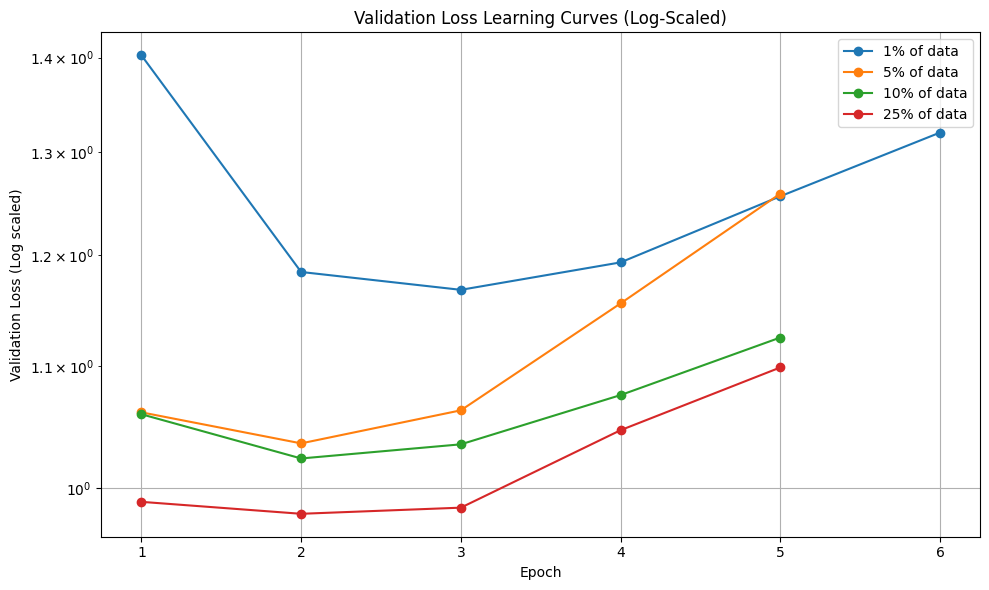

In [27]:
plot_learning_curves([1, 5, 10, 25])

We see that the 1% model needs 6 epochs, while the other three models implemented early stopping at epoch 5. While the training losses were declining for all four models, we can see that this only led to an increase in the validation loss. This is likely due to overfitting on the training data. 

However, we can still see that the loss for the 25% model is the lowest, followed by the 10% model and the 1% model. The loss curve for the 10% model is much closer for the 25% model than it is to the 1% model, which is as we expected.  We can clearly see that operating with more data lowers the validation loss. It is interesting how the 5% and 10% model evaluation loss curves start quite close together, but the loss for the 5% model increases at a higher rate. This makes sense given our aforementioned  overfitting concerns. With half as much data, there is less explanatory power in the 5% data and it will be more prone to noise and randomness.

To Summarize:

- Overall trend: As expected, models trained on larger subsets of the dataset achieve consistently lower validation loss across all epochs. This confirms that the model benefits significantly from more labeled data.
- Convergence speed: The model trained on 25% of the data starts with the lowest loss and converges very quickly — indicating faster and more stable learning. In contrast, the 1% model begins with high loss and exhibits unstable behavior, with a sharp initial drop followed by an upward trend, likely due to overfitting.


We further look into the results through getting the true loss data values and investigating the accuracy, precision, and recall.

Final Evaluation Metrics by Training Percentage:



,Percentage,eval_loss,eval_accuracy,eval_precision,eval_recall,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
0,1,1.1677,0.6355,0.6374,0.6312,5.3577,293.411,9.332,6.0
1,5,1.0357,0.6753,0.6778,0.6702,26.7839,293.460,9.185,5.0
2,10,1.0235,0.6719,0.6679,0.6681,53.6700,292.883,2.944,5.0
3,25,0.9802,0.6829,0.6794,0.6789,133.7428,293.825,2.938,5.0


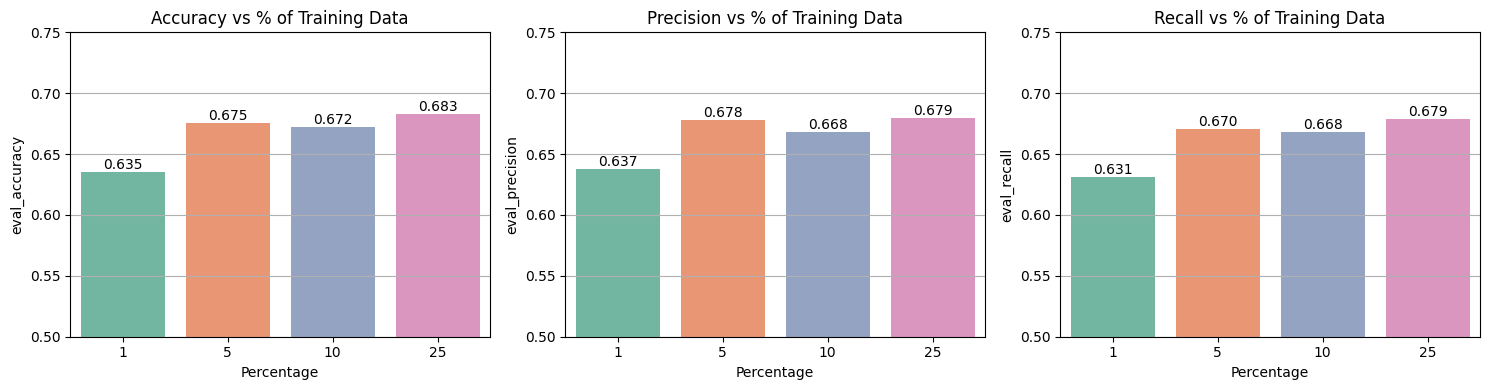

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Path to the saved CSV from earlier training runs (this only has the 1% and 5% in this code workflow)
results_path = "/kaggle/working/bert_part3_results.csv"

# Load previous results
results_df = pd.read_csv(results_path)

# Manually defined exact metrics for 10% and 25%
manual_rows = pd.DataFrame([
    {
        "Percentage": 10,
        "eval_loss": 1.023519278,
        "eval_accuracy": 0.671862078,
        "eval_precision": 0.667920234,
        "eval_recall": 0.668081537,
        "eval_runtime": 53.67,
        "eval_samples_per_second": 292.883,
        "eval_steps_per_second": 2.944,
        "epoch": 5
    },
    {
        "Percentage": 25,
        "eval_loss": 0.980213165,
        "eval_accuracy": 0.68292745,
        "eval_precision": 0.679443436,
        "eval_recall": 0.678873661,
        "eval_runtime": 133.7428,
        "eval_samples_per_second": 293.825,
        "eval_steps_per_second": 2.938,
        "epoch": 5
    }
])

# Combine and remove duplicates based on Percentage
results_df = pd.concat([results_df, manual_rows], ignore_index=True)
results_df = results_df.drop_duplicates(subset=["Percentage"], keep="last")
results_df = results_df.sort_values("Percentage").reset_index(drop=True)

# Round for display
results_df_rounded = results_df.round(4)

# Show updated table
print("Final Evaluation Metrics by Training Percentage:\n")
display(results_df_rounded)

# Plot Accuracy, Precision, Recall
metrics = ["eval_accuracy", "eval_precision", "eval_recall"]
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

for i, metric in enumerate(metrics):
    sns.barplot(ax=axs[i], x="Percentage", y=metric, data=results_df_rounded, palette="Set2")
    axs[i].set_title(f"{metric.replace('eval_', '').capitalize()} vs % of Training Data")
    axs[i].set_ylim(0.5, 0.75)
    axs[i].grid(True, axis="y")

    # Annotate each bar
    for p in axs[i].patches:
        height = p.get_height()
        axs[i].annotate(f"{height:.3f}",
                        (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

Now we observe the graphical representation of the accuracy, precision, and recall.. We see a general trend that adding more data improves the accuracy, precision, and recall. The 1% of the data is worse, while the 10% and 25% models observe quite similar performance. Recall that due to computational cost issues, we were forced to merely re-load the results from a previous execution of the 10% and 25% data implemntations. I believe that this is why we see marginally worse performance in the 10% model than the 5% model. This is noisely and unlikely to sustain itself over many model iterations/simulations.

- The loss reduction from 1% to 10% is 0.16
- The loss reduction from 1% to 5% is 0.16
- The loss reduction from 10% to 25% is 0.04
- The loss reduction from 1% to 25% is 0.20

- The accuracy improvement from 1% to 10% is 0.03
- The accuracy improvement from 1% to 10% is 0.03
- The accuracy improvement from 10% to 25% is 0.01
- The accuracy improvement from 1% to 25% is 0.048

The first 9% of data resulted in a loss reduction of 0.16, and the next 15% of data only resulted in a loss reduction of 0.04. The core patterns in the data are learned early on, and less additional information is gained from the subsequent samples.

Generally, its interseting that we observe the same trends across all three of the accuracy, precision, and recall graphs. There is a rapid jump from 1% to 5%, and then a relative plateau from that point onwards. Generally speaking, its a good sign that minimizing false positives and macro-averaging classes does not come at the expense of overall accuracy.

To further investigate the training results, let's look at confusion matrices. For this part of the code, the environment reset and I didn't have access to the exact same test data that we had above. This was an error in foresight, and we did not have sufficient time to improve the code and run the model again due to computational cost concerns. However, we can write a function to replicate the test set and run the trained model on that corresponding dataset proportion.

We run the model on some unseen proportions to view a confusion matrix. We do this for the 1% and 5% proportions. 

Note that I would have re-done the plot to include the true class names instead of the raw labels, but I lost the raw model data in my kaggle directory.

In [35]:
def get_stratified_test_set(df_model, pct, seed=42):
    df_sample, _ = train_test_split(df_model, train_size=pct, stratify=df_model["label"], random_state=seed)
    _, test_df = train_test_split(df_sample, test_size=0.2, stratify=df_sample["label"], random_state=seed)
    test_ds = Dataset.from_pandas(test_df.reset_index(drop=True)).map(tokenize, batched=True)
    test_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])
    return test_ds

test_01 = get_stratified_test_set(df_model, 0.01)
test_05 = get_stratified_test_set(df_model, 0.05)
test_10 = get_stratified_test_set(df_model, 0.10)
test_25 = get_stratified_test_set(df_model, 0.25)

def plot_confusion_matrix_batched(model_dir, test_dataset, title, tokenizer_ckpt="tirdodbehbehani/yahoo-bert-32shot_stratified_augm_2", batch_size=100):
    from transformers import AutoModelForSequenceClassification, AutoTokenizer
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    from torch.utils.data import DataLoader
    import torch
    import matplotlib.pyplot as plt

    # Load model and tokenizer
    model = AutoModelForSequenceClassification.from_pretrained(model_dir)
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_ckpt)
    model.eval()

    # Use GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Create DataLoader for batching
    dataloader = DataLoader(test_dataset, batch_size=batch_size)

    all_preds, all_labels = [], []

    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].cpu().numpy()

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, axis=-1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels)

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title(title)
    plt.show()

Map:   0%|          | 0/1572 [00:00<?, ? examples/s]

Map:   0%|          | 0/7860 [00:00<?, ? examples/s]

Map:   0%|          | 0/15719 [00:00<?, ? examples/s]

Map:   0%|          | 0/39297 [00:00<?, ? examples/s]

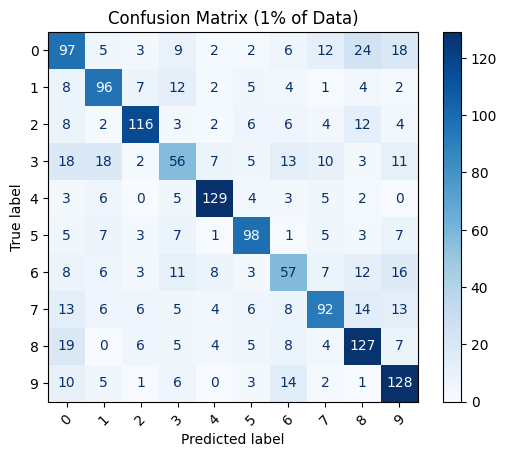

In [37]:
plot_confusion_matrix_batched(
    model_dir="/kaggle/working/yahoo_models/results_1/checkpoint-594",
    test_dataset=test_01,
    title="Confusion Matrix (1% of Data)"
)


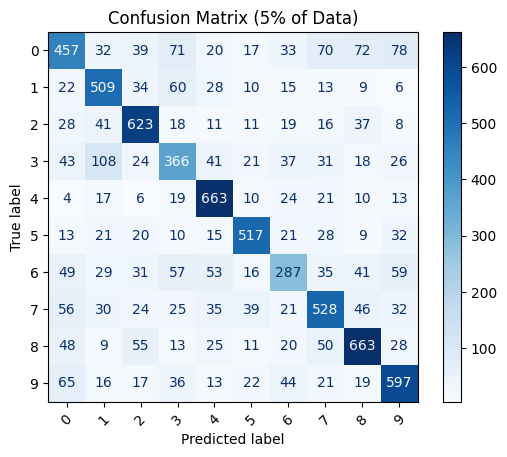

In [34]:
plot_confusion_matrix_batched(
    model_dir="/kaggle/working/yahoo_models/results_5/checkpoint-2460",
    test_dataset=test_05,
    title="Confusion Matrix (5% of Data)"
)


In [ ]:
#plot_confusion_matrix_batched(
#    model_dir="/kaggle/working/yahoo_models/results_25/checkpoint-3930",
#    test_dataset=test_ds_25,
#    title="Confusion Matrix (25% of Data)"
#)

We can see from the confusion matrices perform pretty well. The most common predictions for all 10 classes are the true labels, across both the 1% and 5% proportions. 

Overall, the 5% model displays stronger diagonal dominance — meaning it makes more correct predictions across all classes. In contrast, the 1% model has a few more (relatively) off-diagonal elements, indicating misclassifications were more common.

Note that we do not do the confusion matrices for the other proportions due to the aforementioned session issue. Recall that we have a stratified, balanced dataset, which partially explains the even distribution across the confusion matrix. There is a noticeable difference in the color shade for the matching true/predicted labels than any other mis-classification for any of the 10 labels.

Our most accurate topic labels are Computers & Internet (Label 4) and Family & Relationships (Label 8). It makes sense that these are out best labels, as those are two distinct topic that don't have much crossove into adjacent spaces. Meanwhile, the least accurate topic classification is Business & Finance (6). We suspect that this is because we could observe a fair share of overlap with business into other topics such as Education & Reference (Label 3) and Society & Culture (Label 0)